<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/LSTM_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers import ConvLSTM2D
import seaborn as sns

In [156]:
df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/August-2021%20Mannar%20Wind%20Data1.csv')
df = df.rename(columns = {'TimeStamp': 'Date & Time', 'Average  Wind Speed(m/s)': 'Wind Speed (m/s)', 'Average  Wind Dirction(deg)':'Wind Direction(deg)','Average Active Power(MW)':'Active Power(MW)'}, inplace = False)
df=df[['Date & Time','Wind Speed (m/s)','Wind Direction(deg)','Active Power(MW)']]
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format="%m/%d/%Y %H:%M")
df["Active Power(MW)"] = pd.to_numeric(df["Active Power(MW)"])
#df.set_index('Date & Time',inplace=True)
df_n=df.head(4389)
train_dates=df_n['Date & Time']#separate dates for future plotting
cols=list(df_n)[1:3]
df_for_training= df_n[cols].astype(float)

#print(cols)

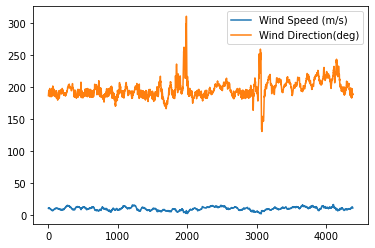

In [157]:
df_for_training.plot()

In [158]:
train_dates.tail(100)

4289   2021-08-31 04:10:00
4290   2021-08-31 04:20:00
4291   2021-08-31 04:30:00
4292   2021-08-31 04:40:00
4293   2021-08-31 04:50:00
               ...        
4384   2021-08-31 20:00:00
4385   2021-08-31 20:10:00
4386   2021-08-31 20:20:00
4387   2021-08-31 20:30:00
4388   2021-08-31 20:40:00
Name: Date & Time, Length: 100, dtype: datetime64[ns]

In [159]:
# df_for_plot=df_for_training.tail(2000)
# df_for_plot.plot.line()
scaler= StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [160]:
trainX=[]
trainY=[]

n_future=1
n_past=15

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [161]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [162]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4374, 15, 2).
trainY shape == (4374, 1).


In [163]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 15, 64)            17152     
_________________________________________________________________
lstm_25 (LSTM)               (None, 15, 32)            12416     
_________________________________________________________________
lstm_26 (LSTM)               (None, 15, 32)            8320      
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
__________________________________________________

In [164]:
history = model.fit(trainX, trainY, epochs=10, batch_size=30, validation_split=0.02, verbose=1)

Epoch 1/10
143/143 [==============================] - 9s 33ms/step - loss: 0.2877 - val_loss: 0.0851
Epoch 2/10
143/143 [==============================] - 4s 30ms/step - loss: 0.1180 - val_loss: 0.0527
Epoch 3/10
143/143 [==============================] - 4s 31ms/step - loss: 0.0822 - val_loss: 0.0379
Epoch 4/10
143/143 [==============================] - 4s 30ms/step - loss: 0.0551 - val_loss: 0.0262
Epoch 5/10
143/143 [==============================] - 4s 30ms/step - loss: 0.0474 - val_loss: 0.0100
Epoch 6/10
143/143 [==============================] - 4s 30ms/step - loss: 0.0403 - val_loss: 0.0161
Epoch 7/10
143/143 [==============================] - 4s 30ms/step - loss: 0.0285 - val_loss: 0.0095
Epoch 8/10
143/143 [==============================] - 4s 30ms/step - loss: 0.0264 - val_loss: 0.0055
Epoch 9/10
143/143 [==============================] - 4s 31ms/step - loss: 0.0271 - val_loss: 0.0129
Epoch 10/10
143/143 [==============================] - 4s 31ms/step - loss: 0.0233 - val_lo

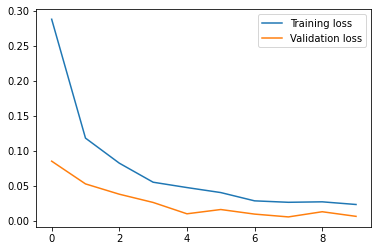

In [165]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [166]:
n_future=20
forecast_period_dates=pd.date_range(list(train_dates)[-1],periods=n_future,freq='10min')

In [167]:
forecast=model.predict(trainX[-n_future:])

In [168]:
forecast_copies =np.repeat(forecast,df_for_training.shape[1],axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

In [169]:
forecast_dates=[]
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

In [170]:
df_forecast=pd.DataFrame({'Date & Time':np.array(forecast_period_dates),'Wind Speed (m/s)':y_pred_future})
df_forecast['Date & Time']=pd.to_datetime(df_forecast['Date & Time'])

In [171]:
original=df[['Date & Time','Wind Speed (m/s)']]
original['Date & Time']=pd.to_datetime(original['Date & Time'])
original=original.loc[original['Date & Time'] >= '2021-08-31 07:30:00']
            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


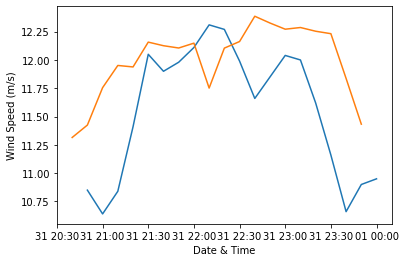

In [172]:
sns.lineplot(original['Date & Time'][-n_future:],original['Wind Speed (m/s)'][-n_future-1:])
sns.lineplot(df_forecast['Date & Time'],df_forecast['Wind Speed (m/s)'])

In [173]:
from sklearn.metrics import mean_squared_error

In [174]:
mean_squared_error(original['Wind Speed (m/s)'][-n_future:],df_forecast['Wind Speed (m/s)'])

0.4144869670088844